In [1]:
BASE_PROJECT_DIR = '/home/akhanal1/ature'
BASE_PROJECT_DIR = '/home/ak/PycharmProjects/ature'

import os
import sys
import traceback

sys.path.append(BASE_PROJECT_DIR)
os.chdir(BASE_PROJECT_DIR)

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from utils import img_utils as iu
sep = os.sep
import torch
%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image as IMG
import utils.img_utils as iu
from commons.IMAGE import Image
import json

In [3]:
import torch
import torch.optim as optim
from neuralnet.unet.model import UNet
from neuralnet.unet.unet_dataloader import PatchesGenerator
from neuralnet.unet.unet_trainer import UNetNNTrainer
import torchvision.transforms as transforms
import neuralnet.utils.auto_split as asp
from neuralnet.utils.measurements import get_best_f1_thr

from neuralnet.unet.runs import DRIVE as unetDRIVE
from neuralnet.thrnet.runs import DRIVE32
from neuralnet.thrnet.runs import DRIVE16
from neuralnet.thrnet.runs import DRIVE32

122394


In [27]:
train_val = pd.read_csv(thrDRIVE['Dirs']['logs']+sep+'THRNET-DRIVE.chk.tar-TRAIN.csv', index_col='TYPE')
val = train_val.query('TYPE==1')
T_val = np.arange(val.shape[0])
train = train_val.query('TYPE==0')
T_train =np.arange(train.shape[0])
test= pd.read_csv(thrDRIVE['Dirs']['logs']+sep+'THRNET-DRIVE.chk.tar-TEST.csv', index_col='TYPE')
T_test = np.arange(test.shape[0])

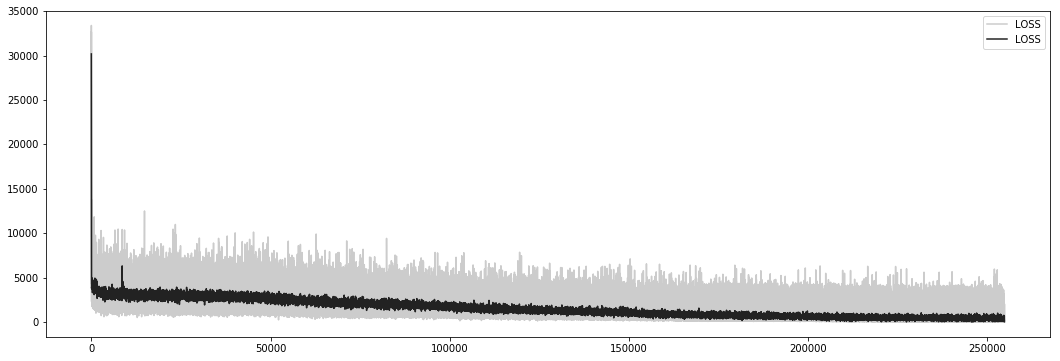

In [14]:
plt.rcParams["figure.figsize"] = [18,6]
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
df = train.copy()
df['LOSS'] = savgol_filter(df['LOSS'], 51, 2)
plots = train.plot(y='LOSS', x=T_train, c='#cccccc', ax=ax1)
plots = df.plot(y='LOSS', x=T_train, c='#222222', ax=ax1)
plt.show()

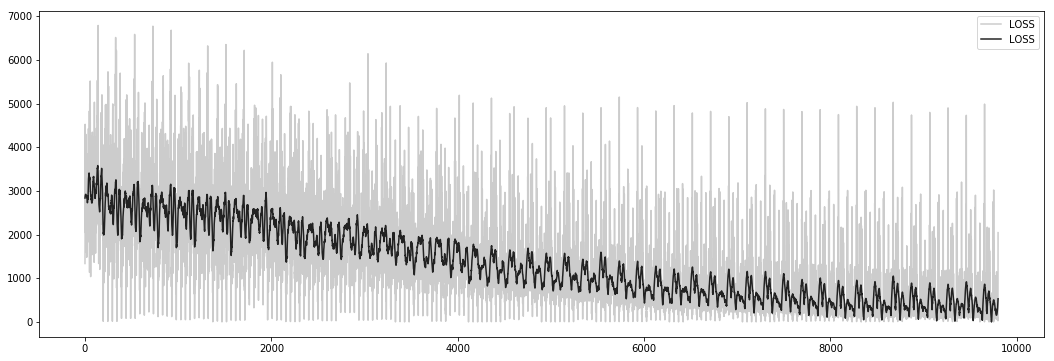

In [19]:
plt.rcParams["figure.figsize"] = [18,6]
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
df = val.copy()
df['LOSS'] = savgol_filter(df['LOSS'], 51, 3)
plots = val.plot(y='LOSS', x=T_val, c='#cccccc', ax=ax1)
plots = df.plot(y='LOSS', x=T_val, c='#222222', ax=ax1)
plt.show()

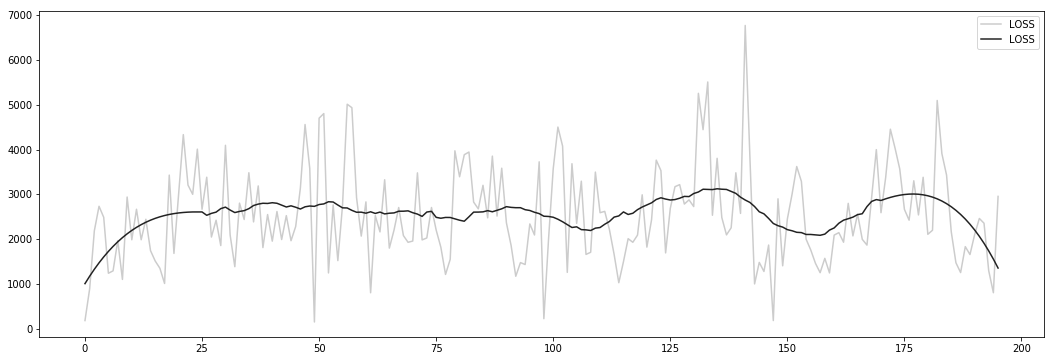

In [28]:
plt.rcParams["figure.figsize"] = [18,6]
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
df = test.copy()
df['LOSS'] = savgol_filter(df['LOSS'], 51, 3)
plots = test.plot(y='LOSS', x=T_test, c='#cccccc', ax=ax1)
plots = df.plot(y='LOSS', x=T_test, c='#222222', ax=ax1)
plt.show()

### TEST Images

In [4]:
imap = Image()

In [5]:
file = '19_test.png'
imap.load_file(unetDRIVE['Dirs']['image'],  '19_test.tif')
imap.res['unet'] = iu.get_image_as_array(unetDRIVE['Dirs']['logs']+sep+file, channels=1)
imap.res['thrnet'] = iu.get_image_as_array(DRIVE16['Dirs']['logs']+sep+file, channels=1)
imap.load_ground_truth(unetDRIVE['Dirs']['truth'], unetDRIVE['Funcs']['truth_getter'])
imap.load_mask(unetDRIVE['Dirs']['mask'], unetDRIVE['Funcs']['mask_getter'])

In [6]:
DRIVE32['Dirs']

{'image': 'data/DRIVE_UNET_MAP/images',
 'logs': 'data/DRIVE_UNET_MAP/thrnet32_logs',
 'mask': 'data/DRIVE/mask',
 'truth': 'data/DRIVE/manual'}

In [7]:
ig = imap.res['thrnet'].copy()
ig[imap.mask==0] = 0
iu.get_praf1(ig, imap.ground_truth)

{'Accuracy': 0.97234, 'F1': 0.84733, 'Precision': 0.78136, 'Recall': 0.92547}

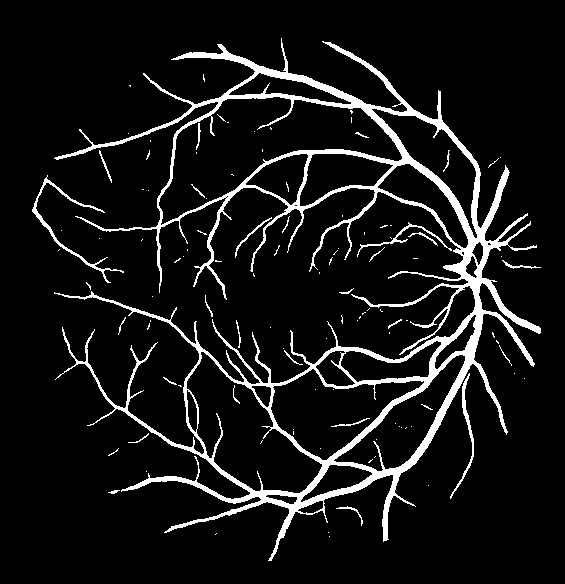

In [106]:
IMG.fromarray(ig)

### Find manual scores with threshodl for each batch

In [11]:
patch_shape = (32, 32)
p_offset = (30, 30)
ixes = list(iu.get_chunk_indexes(imap.image_arr[:,:,1].shape, patch_shape, p_offset))
patches = []
for i in ixes:
    p,q,r,s = i
    patch = imap.res['unet'][p:q,r:s].copy()
    y = imap.ground_truth[p:q,r:s]
    f1,t = get_best_f1_thr(patch, y)
#     print(f1, t)
    patch[patch>t] = 255
    patch[patch<t]=0
    patches.append(patch)

In [12]:
merged = iu.merge_patches(np.array(patches), imap.res['unet'].shape, patch_shape, p_offset)
iu.get_praf1(merged, imap.ground_truth)

{'Accuracy': 0.98228, 'F1': 0.89447, 'Precision': 0.88456, 'Recall': 0.90461}

In [57]:
# iu.get_praf1(ig, imap.ground_truth)

{'Accuracy': 0.96717, 'F1': 0.80163, 'Precision': 0.83487, 'Recall': 0.77093}

In [77]:
get_best_f1_thr(imap.res['unet'], imap.ground_truth)

({'Accuracy': 0.97975, 'F1': 0.87524, 'Precision': 0.89499, 'Recall': 0.85634},
 175.0)

In [8]:
j = imap.res['unet'].copy()
j[j>=155] = 255
j[j<155]=0
iu.get_praf1(j, imap.ground_truth)

{'Accuracy': 0.97792, 'F1': 0.87057, 'Precision': 0.84722, 'Recall': 0.89525}

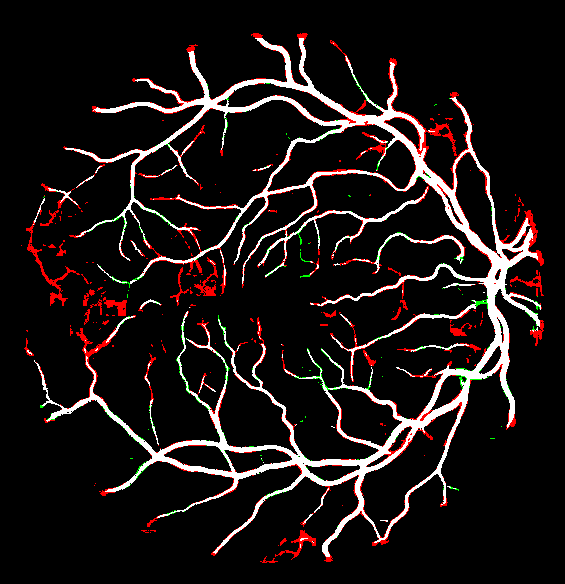

In [42]:
IMG.fromarray(iu.get_rgb_scores(ig, merged))

In [125]:
a = torch.rand((4,4))

In [126]:
b = torch.rand((4,4))

In [131]:
d = torch.max(a,b)

In [136]:
torch.max(a,1)

(tensor([ 0.9166,  0.8981,  0.5940,  0.8148]), tensor([ 3,  2,  3,  1]))

In [137]:
torch.max(a,b)

tensor([[ 0.2561,  0.7137,  0.9821,  0.9166],
        [ 0.7648,  0.6572,  0.8981,  0.2898],
        [ 0.2743,  0.4434,  0.7790,  0.6937],
        [ 0.6079,  0.8148,  0.4309,  0.7792]])